In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import prep_dataset as prep

import time
import numpy as np

# Patch-based traversability neural network

### Definition of custom dataset

In [ ]:
class DualInputDataset(Dataset):
    def __init__(self, rgb_dir, ir_dir, annotations_file, rgb_transform=None, ir_transform=None):
        self.rgb_dir = rgb_dir
        self.ir_dir = ir_dir
        self.annotations = pd.read_csv(annotations_file)
        self.rgb_transform = rgb_transform
        self.ir_transform = ir_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        rgb_img_name = os.path.join(self.rgb_dir, self.annotations.iloc[idx, 0])
        ir_img_name = os.path.join(self.ir_dir, self.annotations.iloc[idx, 1])
        label1 = self.annotations.iloc[idx, 2]  # First label
        label2 = self.annotations.iloc[idx, 3]  # Second label
        label3 = self.annotations.iloc[idx,4]
        confidence = self.annotations.iloc[idx, 5]  # Confidence value

        rgb_image = Image.open(rgb_img_name).convert('RGB')
        ir_image = Image.open(ir_img_name).convert('L')  # Convert to grayscale

        if self.rgb_transform:
            rgb_image = self.rgb_transform(rgb_image)
        if self.ir_transform:
            ir_image = self.ir_transform(ir_image)

        return rgb_image, ir_image, label1, label2, label3, confidence

### Definition of MISO Network

In [ ]:
class CReLU(nn.Module):
    def forward(self, x):
        return torch.cat((torch.relu(x), torch.relu(-x)), dim=1)


In [ ]:
class MISONet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(MISONet, self).__init__()
        self.resnet_rgb = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet_ir = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Modify the first convolutional layer for the IR branch to accept single channel input
        self.resnet_ir.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the final fully connected layer from both ResNets
        self.resnet_rgb = nn.Sequential(*list(self.resnet_rgb.children())[:-1])
        self.resnet_ir = nn.Sequential(*list(self.resnet_ir.children())[:-1])

        # Define the final fully connected layers with dropout
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(), #CReLU(),#nn.LeakyReLU(),#
            nn.Dropout(dropout_prob),  # Dropout after the first ReLU
            nn.Linear(256, 128),
            nn.ReLU(), #CReLU(),#nn.LeakyReLU(),#nn.ReLU(),#CReLU(),#nn.LeakyReLU(),#CReLU(),#
            nn.Dropout(dropout_prob),  # Dropout after the second ReLU
            nn.Linear(128, 3)  # Output 3 values for the three labels
        )

    def forward(self, rgb_image, ir_image):
        rgb_features = self.resnet_rgb(rgb_image)
        ir_features = self.resnet_ir(ir_image)

        # Flatten the features
        rgb_features = rgb_features.view(rgb_features.size(0), -1)
        ir_features = ir_features.view(ir_features.size(0), -1)

        # Concatenate the features
        combined_features = torch.cat((rgb_features, ir_features), dim=1)

        # Pass through the final fully connected layer
        output = self.fc(combined_features)
        return output

### Data transformations and Data Loader

In [2]:
Combined_out = "/media/philip/Elements/speciale_dataset/combined/"
#os.makedirs(Combined_out)

In [ ]:
# Define transformations for RGB images
rgb_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB
])

# Define transformations for IR images
ir_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale (single channel)
])

# Create dataset and data loader
rgb_dir =Combined_out+"RGB_patches" # prep.merge_image_datasets_wPattern("/media/philip/Elements/speciale_dataset/data/", Combined_out, "RGB_patches" )#
ir_dir = Combined_out+"IR_patches"# prep.merge_image_datasets_wPattern("/media/philip/Elements/speciale_dataset/data/", Combined_out, "IR_patches" )#
annotations_file = Combined_out+"merged_dataset.csv"#prep.combine_csv("/media/philip/Elements/speciale_dataset/data/", Combined_out)#

dataset = DualInputDataset(rgb_dir, ir_dir, annotations_file, rgb_transform=rgb_transform, ir_transform=ir_transform)
# Split the dataset into training, validation, and testing sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
#train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
#val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Initialize model

In [ ]:
# Initialize the network, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MISONet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)


# s = time.gmtime(time.time())
# logs_address = 'logs/'+time.strftime('%Y-%m-%d_%H:%M:%S',s)+'prelu'
# writer = SummaryWriter(logs_address)

### Define weighted MSE loss function

In [ ]:
def weighted_mse_loss(outputs, labels, confidence):
    """
    Compute weighted MSE loss.

    Args:
        outputs (torch.Tensor): Model predictions of shape (batch_size, num_outputs).
        labels (torch.Tensor): Ground truth labels of shape (batch_size, num_outputs).
        confidence (torch.Tensor): Confidence values of shape (batch_size,).

    Returns:
        torch.Tensor: Weighted MSE loss.
    """
    # Compute squared errors
    squared_errors = (outputs - labels) ** 2  # Shape: (batch_size, num_outputs)

    # Weight the squared errors by confidence
    weighted_squared_errors = squared_errors * confidence.unsqueeze(1)  # Shape: (batch_size, num_outputs)

    # Compute the mean of the weighted squared errors
    loss = weighted_squared_errors.mean()
    return loss



### Visualize model

In [ ]:
import os
import torch
from torchviz import make_dot

# Define the output folder for visualizations
output_folder = "/home/philip/uni/speciale/code_ws/src/PatchTrav/misonet_visualizations/"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get a batch of samples from the dataset
sample_batch = next(iter(train_loader))  # Fetch one batch from train_loader
sample_rgb, sample_ir = sample_batch[:2]  # Extract only RGB and IR images

# Move samples to the same device as the model
sample_rgb, sample_ir = sample_rgb.to(device), sample_ir.to(device)

# Function to render and save visualizations
def save_visualization(dot, filename):
    dot.format = 'png'
    dot.render(os.path.join(output_folder, filename))

# Visualize only the RGB branch
rgb_branch = model.resnet_rgb
output_rgb = rgb_branch(sample_rgb)
dot_rgb = make_dot(output_rgb, params=dict(rgb_branch.named_parameters()))
save_visualization(dot_rgb, 'rgb_branch_architecture')

# Visualize only the IR branch
ir_branch = model.resnet_ir
output_ir = ir_branch(sample_ir)
dot_ir = make_dot(output_ir, params=dict(ir_branch.named_parameters()))
save_visualization(dot_ir, 'ir_branch_architecture')

# Visualize the final fully connected layers
fc_input = torch.cat((output_rgb.view(output_rgb.size(0), -1),
                      output_ir.view(output_ir.size(0), -1)), dim=1)
fc_output = model.fc(fc_input)
dot_fc = make_dot(fc_output, params=dict(model.fc.named_parameters()))
save_visualization(dot_fc, 'fc_architecture')

# Generate overall model output for visualization
output = model(sample_rgb, sample_ir)

# Simplified visualization
dot_simple = make_dot(output, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
save_visualization(dot_simple, 'simplified_misonet_architecture')

# Visualize only the forward pass
dot_forward = make_dot(output, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
save_visualization(dot_forward, 'forward_pass_only')

# Generate the full visualization
dot_full = make_dot(output, params=dict(model.named_parameters()))
save_visualization(dot_full, 'misonet_architecture')

print(f"✅ Visualizations saved in '{output_folder}'")

✅ Visualizations saved in '/home/philip/uni/speciale/code_ws/src/PatchTrav/misonet_visualizations/'


### Training loop

In [ ]:
# Filepaths for the validation dataset (completely different dataset)
val_rgb_dir = "/media/philip/Elements/speciale_dataset/validation/data_set0/RGB_patches"  # Replace with your validation RGB path
val_ir_dir = "/media/philip/Elements/speciale_dataset/validation/data_set0/IR_patches"    # Replace with your validation IR path
val_annotations_file = "/media/philip/Elements/speciale_dataset/validation/data_set0/annotations.csv"  # Replace with your validation annotations path

val_dataset = DualInputDataset(val_rgb_dir, val_ir_dir, val_annotations_file, rgb_transform=rgb_transform, ir_transform=ir_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Validation set from a different dataset

In [ ]:
# Early stopping parameters
patience = 100  # Number of test evaluations to wait before stopping
min_delta = 0.001  # Minimum improvement required to reset patience
best_loss = float('inf')  # Initialize best loss as infinity
epochs_without_improvement = 0  # Counter for patience

load_nr = 0
num_epochs = 501
test_losses = []  # Store test losses


outputs_list, labels_list, conf_list = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for rgb_images, ir_images, label1, label2, label3, confidence in train_loader:
        rgb_images = rgb_images.to(device)
        ir_images = ir_images.to(device)
        label1 = label1.float().to(device)
        label2 = label2.float().to(device)
        label3 = label3.float().to(device)
        confidence = confidence.float().to(device)

        optimizer.zero_grad()

        outputs = model(rgb_images, ir_images)
        outputs = outputs.squeeze()
        labels = torch.stack((label1, label2, label3), dim=1)  # Combine labels

        # Compute weighted MSE loss
        loss = weighted_mse_loss(outputs, labels, confidence)
        loss.backward()
        optimizer.step()

        writer.add_scalar("Loss/Train", loss, epoch)
        running_train_loss += loss.item()

    # Save model every 50 epochs
    if epoch % 50 == 0:
        torch.save(model.state_dict(), 'model_weights/' + time.strftime('%Y-%m-%d_%H:%M:%S', time.gmtime()) + f'_{load_nr+epoch}_prelu_model_weight.pth')

    # Run test every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for rgb_images, ir_images, label1, label2, label3, confidence in test_loader:
                rgb_images = rgb_images.to(device)
                ir_images = ir_images.to(device)
                label1 = label1.float().to(device)
                label2 = label2.float().to(device)
                label3 = label3.float().to(device)
                confidence = confidence.float().to(device)

                outputs = model(rgb_images, ir_images)
                outputs = outputs.squeeze()
                labels = torch.stack((label1, label2, label3), dim=1)

                loss = weighted_mse_loss(outputs, labels, confidence)
                running_test_loss += loss.item()

        test_loss = running_test_loss / len(test_loader)
        test_losses.append((epoch, test_loss))
        writer.add_scalar("Loss/Test", test_loss, epoch)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')

        # Early stopping logic
        if best_loss - test_loss > min_delta:
            best_loss = test_loss
            epochs_without_improvement = 0  # Reset patience counter
        else:
            epochs_without_improvement += 1
            print(f'No significant improvement in test loss for {epochs_without_improvement}/{patience} evaluations.')

        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}.')
            break  # Stop training

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for rgb_images, ir_images, label1, label2, label3, confidence in val_loader:
                rgb_images = rgb_images.to(device)
                ir_images = ir_images.to(device)
                label1 = label1.float().to(device)
                label2 = label2.float().to(device)
                label3 = label3.float().to(device)
                confidence = confidence.float().to(device)

                outputs = model(rgb_images, ir_images)
                outputs = outputs.squeeze()
                labels = torch.stack((label1, label2, label3), dim=1)

                # Store outputs, labels, and confidence for visualization
                outputs_list.append(outputs.cpu())
                labels_list.append(labels.cpu())
                conf_list.append(confidence.cpu())

                # Compute weighted MSE loss (original labels, no modification)
                loss = weighted_mse_loss(outputs, labels, confidence)
                running_val_loss += loss.item()

            # Calculate average validation loss
            val_loss = running_val_loss / len(val_loader)
            writer.add_scalar("Loss/Val", val_loss, epoch)
            print(f'Validation Loss: {val_loss:.4f}')
    # Print epoch loss
    train_loss = running_train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

Epoch [1/501], Test Loss: 56186.1377
Validation Loss: 5599.7251
Epoch [1/501], Train Loss: 43253.9595
Epoch [2/501], Train Loss: 38720.3676
Epoch [3/501], Train Loss: 42726.6702
Epoch [4/501], Train Loss: 37452.1288
Epoch [5/501], Train Loss: 34568.8556
Epoch [6/501], Train Loss: 32195.0144
Epoch [7/501], Train Loss: 31177.4002
Epoch [8/501], Train Loss: 30243.0284
Epoch [9/501], Train Loss: 27960.8003
Epoch [10/501], Train Loss: 24351.6998
Epoch [11/501], Test Loss: 28464.2190
Validation Loss: 1721.3206
Epoch [11/501], Train Loss: 22473.1341
Epoch [12/501], Train Loss: 21931.0964
Epoch [13/501], Train Loss: 19970.1291
Epoch [14/501], Train Loss: 20095.6395
Epoch [15/501], Train Loss: 17404.5502
Epoch [16/501], Train Loss: 18840.5530
Epoch [17/501], Train Loss: 18602.4186
Epoch [18/501], Train Loss: 16140.7190
Epoch [19/501], Train Loss: 15246.2239
Epoch [20/501], Train Loss: 11780.6199
Epoch [21/501], Test Loss: 12082.6925
Validation Loss: 368.1944
Epoch [21/501], Train Loss: 12392.39

In [ ]:

latest_output = outputs.detach()
print(latest_output)

tensor([[-3.3765e+00,  5.9234e+01,  2.6162e+02],
        [-6.7727e+00,  2.4376e+02,  1.1897e+03],
        [-2.0503e+00,  1.9521e+01,  1.2790e+02],
        [-1.0257e+00,  6.3639e+01,  2.2274e+02],
        [ 1.7024e+00,  8.2173e+00,  2.6932e+01],
        [ 1.5208e+00,  1.0935e+01,  5.2973e+01],
        [-1.4723e+00,  1.0614e+01,  5.8559e+01],
        [ 1.1227e+00,  1.3908e+01,  4.5533e+01],
        [-8.1272e-03,  1.7669e+01,  7.4441e+01],
        [-2.0959e-01,  1.9775e+01,  8.5345e+01],
        [ 3.6137e-01,  5.5695e+01,  2.1929e+02],
        [ 2.4100e+00,  1.0981e+01,  3.5413e+01],
        [-1.4746e+00,  1.2833e+02,  3.2429e+02],
        [ 5.0458e-01,  1.4359e+01,  4.7323e+01],
        [ 3.9971e-01,  1.3795e+01,  7.7401e+01],
        [-2.5643e+00,  8.8536e+01,  2.6710e+02],
        [-3.1635e-01,  1.4003e+01,  5.4912e+01],
        [-2.8758e+00,  1.6292e+01,  7.8208e+01],
        [-2.8623e-01,  2.5721e+01,  7.7264e+01],
        [-1.1125e+00,  8.7470e+01,  5.9675e+02],
        [-1.7588e+00

### Model evaluation

In [ ]:
#Load model

state_dict = torch.load("model_weights/2025-02-15_21:39:38_500_model_weight.pth")
model.load_state_dict(state_dict)

/tmp/ipykernel_18223/1101207951.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("model_weights/2025-02-15_21:39:38_500_model_weight.pth")


<All keys matched successfully>

#### Load validation set

In [ ]:
# Filepaths for the validation dataset (completely different dataset)
val_rgb_dir = "/media/philip/Elements/speciale_dataset/validation/data_set0/RGB_patches"  # Replace with your validation RGB path
val_ir_dir = "/media/philip/Elements/speciale_dataset/validation/data_set0/IR_patches"    # Replace with your validation IR path
val_annotations_file = "/media/philip/Elements/speciale_dataset/validation/data_set0/annotations.csv"  # Replace with your validation annotations path

val_dataset = DualInputDataset(val_rgb_dir, val_ir_dir, val_annotations_file, rgb_transform=rgb_transform, ir_transform=ir_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Validation set from a different dataset

#### Perform validation

In [ ]:
# Validation loop
model.eval()
running_val_loss = 0.0
outputs_list, labels_list, conf_list = [], [], []

with torch.no_grad():
            for rgb_images, ir_images, label1, label2, label3, confidence in val_loader:
                rgb_images = rgb_images.to(device)
                ir_images = ir_images.to(device)
                label1 = label1.float().to(device)
                label2 = label2.float().to(device)
                label3 = label3.float().to(device)
                confidence = confidence.float().to(device)

                outputs = model(rgb_images, ir_images)
                outputs = outputs.squeeze()
                labels = torch.stack((label1, label2, label3), dim=1)

                # Store outputs, labels, and confidence for visualization
                outputs_list.append(outputs.cpu())
                labels_list.append(labels.cpu())
                conf_list.append(confidence.cpu())

                # Compute weighted MSE loss (original labels, no modification)
                loss = weighted_mse_loss(outputs, labels, confidence)
                running_val_loss += loss.item()

            # Calculate average validation loss
            val_loss = running_val_loss / len(val_loader)
            #writer.add_scalar("Loss/Val", val_loss, epoch)
            print(f'Validation Loss: {val_loss:.4f}')

Validation Loss: 928.2716


In [ ]:
latest_output = outputs.detach()
print(latest_output)

tensor([[-2.9637e-01,  1.0619e+01,  6.4854e+01],
        [-2.8385e-01,  1.0973e+01,  6.2805e+01],
        [-3.3768e-02,  1.5049e+01,  6.0161e+01],
        [ 1.2637e-02,  1.1440e+01,  5.7667e+01],
        [ 1.1780e-01,  9.9789e+00,  5.4511e+01],
        [-7.1167e-01,  1.7581e+01,  7.6316e+01],
        [-3.9823e-02,  7.2141e+00,  5.5218e+01],
        [-4.5571e-02,  1.1912e+01,  5.6301e+01],
        [-4.0733e-01,  1.5501e+01,  7.7702e+01],
        [ 1.6181e-01,  1.0125e+01,  5.1449e+01],
        [ 6.0592e-02,  8.9727e+00,  5.6095e+01],
        [-9.6724e-02,  1.2763e+01,  5.9340e+01],
        [-5.5830e-01,  1.5325e+01,  7.4887e+01],
        [ 3.1896e-01,  9.3387e+00,  4.6930e+01],
        [ 2.0408e-01,  8.2285e+00,  5.1642e+01],
        [-1.3335e-02,  7.9519e+00,  5.9489e+01],
        [ 1.1225e-01,  9.7133e+00,  5.2479e+01],
        [-3.1680e-01,  1.2086e+01,  6.3848e+01],
        [-6.8689e-01,  1.6747e+01,  7.7664e+01],
        [-1.2242e-01,  9.1414e+00,  6.0185e+01],
        [-1.9127e-01

#### Plot training, validation, and test losses

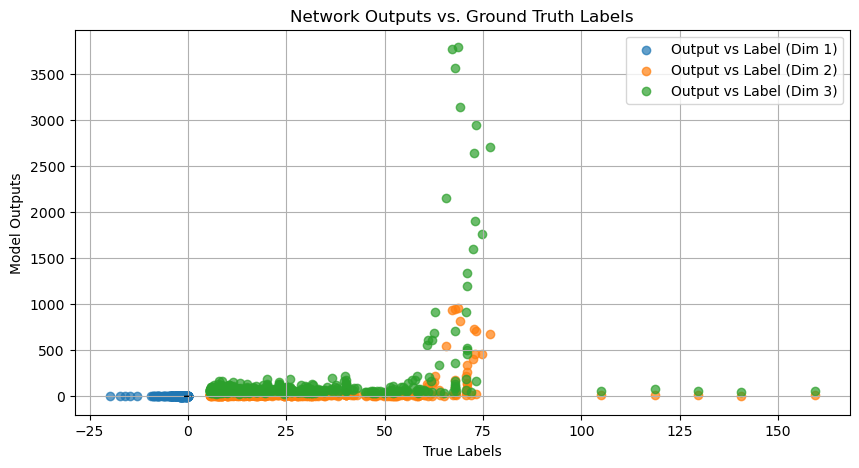

In [ ]:
# Convert lists to tensors for plotting
outputs_all = torch.cat(outputs_list, dim=0)
labels_all = torch.cat(labels_list, dim=0)

# Plot outputs vs labels
plt.figure(figsize=(10, 5))
plt.scatter(labels_all[:, 0], outputs_all[:, 0], label='Output vs Label (Dim 1)', alpha=0.7)
plt.scatter(labels_all[:, 1], outputs_all[:, 1], label='Output vs Label (Dim 2)', alpha=0.7)
plt.scatter(labels_all[:, 1], outputs_all[:, 2], label='Output vs Label (Dim 3)', alpha=0.7)
plt.plot([-1, 1], [-1, 1], 'k--', linewidth=1)  # Diagonal reference line
plt.xlabel('True Labels')
plt.ylabel('Model Outputs')
plt.title('Network Outputs vs. Ground Truth Labels')
plt.legend()
plt.grid(True)
plt.show()

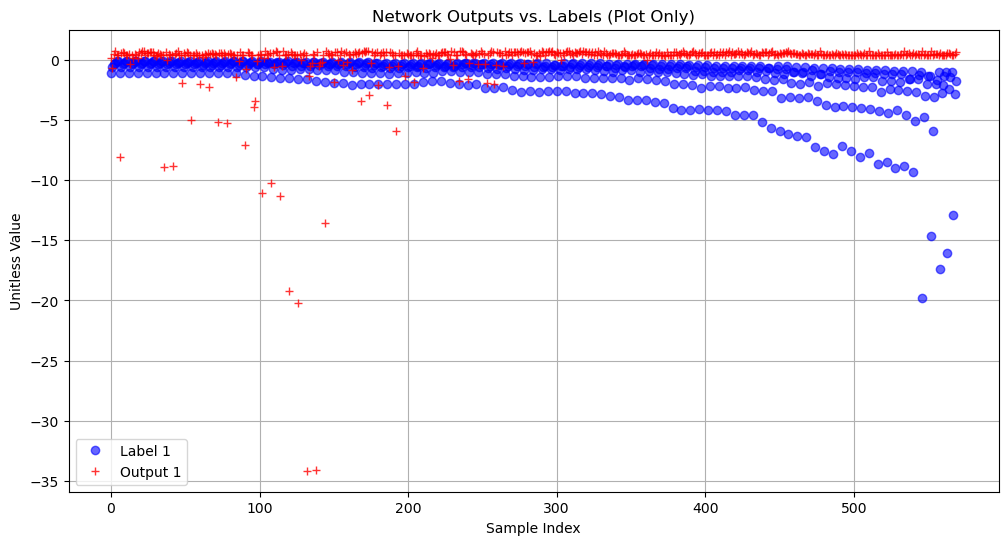

In [ ]:
# Convert lists to tensors for plotting
outputs_all = torch.cat(outputs_list, dim=0).numpy()
labels_all = torch.cat(labels_list, dim=0).numpy()
conf_all = torch.cat(conf_list, dim=0).numpy()

# Apply confidence weighting **only for plotting**
labels_weighted = labels_all #* conf_all[:, np.newaxis]

# Create x-axis indices
num_samples = outputs_all.shape[0]
indices = np.arange(num_samples)

# Plot outputs and confidence-weighted labels
plt.figure(figsize=(12, 6))
plt.plot(indices, labels_weighted[:, 0], 'bo', label='Label 1', alpha=0.6)  # Blue for weighted label1
#plt.plot(indices, labels_weighted[:, 1], 'go', label='Weighted Label 2', alpha=0.6)  # Green for weighted label2
#plt.plot(indices, labels_weighted[:, 2], 'yo', label='Weighted Label 2', alpha=0.6)  # Green for weighted label2
plt.plot(indices, outputs_all[:, 0], 'r+', label='Output 1', alpha=0.8)  # Red for output1
#plt.plot(indices, outputs_all[:, 1], 'm+', label='Output 2', alpha=0.8)  # Magenta for output2
#plt.plot(indices, outputs_all[:, 2], 'c+', label='Output 2', alpha=0.8)  # Magenta for output2
plt.xlabel('Sample Index')
plt.ylabel('Unitless Value')
plt.title('Network Outputs vs. Labels (Plot Only)')
plt.legend()
plt.grid(True)
plt.show()

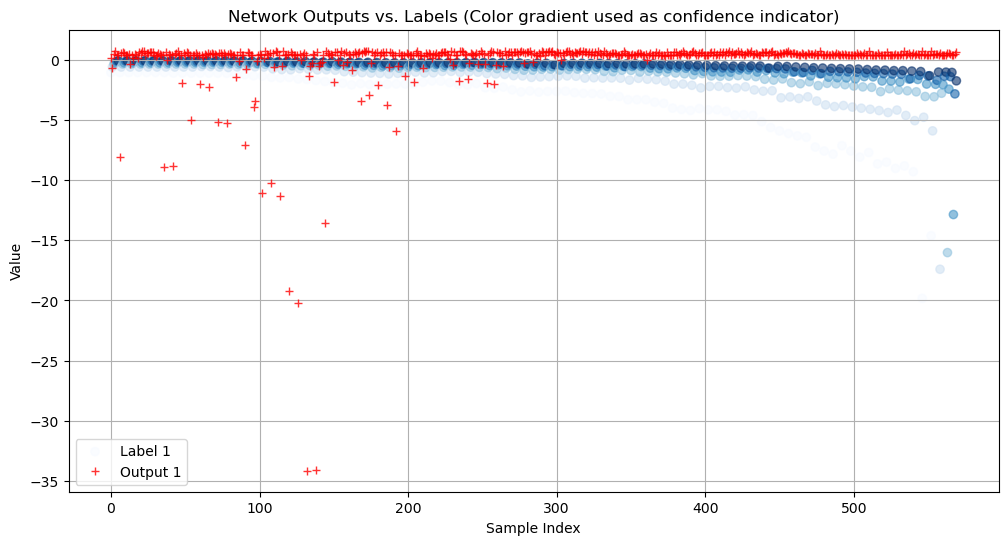

In [ ]:
# Convert lists to tensors for plotting
outputs_all = torch.cat(outputs_list, dim=0).numpy()
labels_all = torch.cat(labels_list, dim=0).numpy()
conf_all = torch.cat(conf_list, dim=0).numpy()

# Apply confidence weighting **only for plotting**
labels_weighted = labels_all #* conf_all[:, np.newaxis]

# Create x-axis indices
num_samples = outputs_all.shape[0]
indices = np.arange(num_samples)

# Normalize confidence values for colormap
conf_norm = (conf_all - conf_all.min()) / (conf_all.max() - conf_all.min() + 1e-6)  # Avoid division by zero

# Create color maps for weighted labels
colors_label1 = plt.cm.Blues(conf_norm)
#colors_label2 = plt.cm.Greens(conf_norm)
#colors_label3 = plt.cm.Reds(conf_norm)
# Plot outputs and confidence-weighted labels
plt.figure(figsize=(12, 6))

# Weighted labels (scatter with confidence-based colors)
plt.scatter(indices, labels_weighted[:, 0], color=colors_label1, label='Label 1', alpha=0.6)
#plt.scatter(indices, labels_weighted[:, 1], color=colors_label2, label='Weighted Label 2', alpha=0.6)
#plt.scatter(indices, labels_weighted[:, 2], color=colors_label3, label='Weighted Label 3', alpha=0.6)  # Green for weighted label2
# Network outputs (fixed colors)
plt.plot(indices, outputs_all[:, 0], 'r+', label='Output 1', alpha=0.8)  # Red for output1
#plt.plot(indices, outputs_all[:, 1], 'm+', label='Output 2', alpha=0.8)  # Magenta for output2
#plt.plot(indices, outputs_all[:, 2], 'c+', label='Output 3', alpha=0.8)  # Magenta for output3
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Network Outputs vs. Labels (Color gradient used as confidence indicator)')
plt.legend()
plt.grid(True)
plt.show()

### Box plot for confidences

In [ ]:
def clip_outliers(errors, lower_quantile=0.05, upper_quantile=0.95):
    """Clips values outside the given quantile range."""
    lower, upper = np.quantile(errors, [lower_quantile, upper_quantile])
    return np.clip(errors, lower, upper)


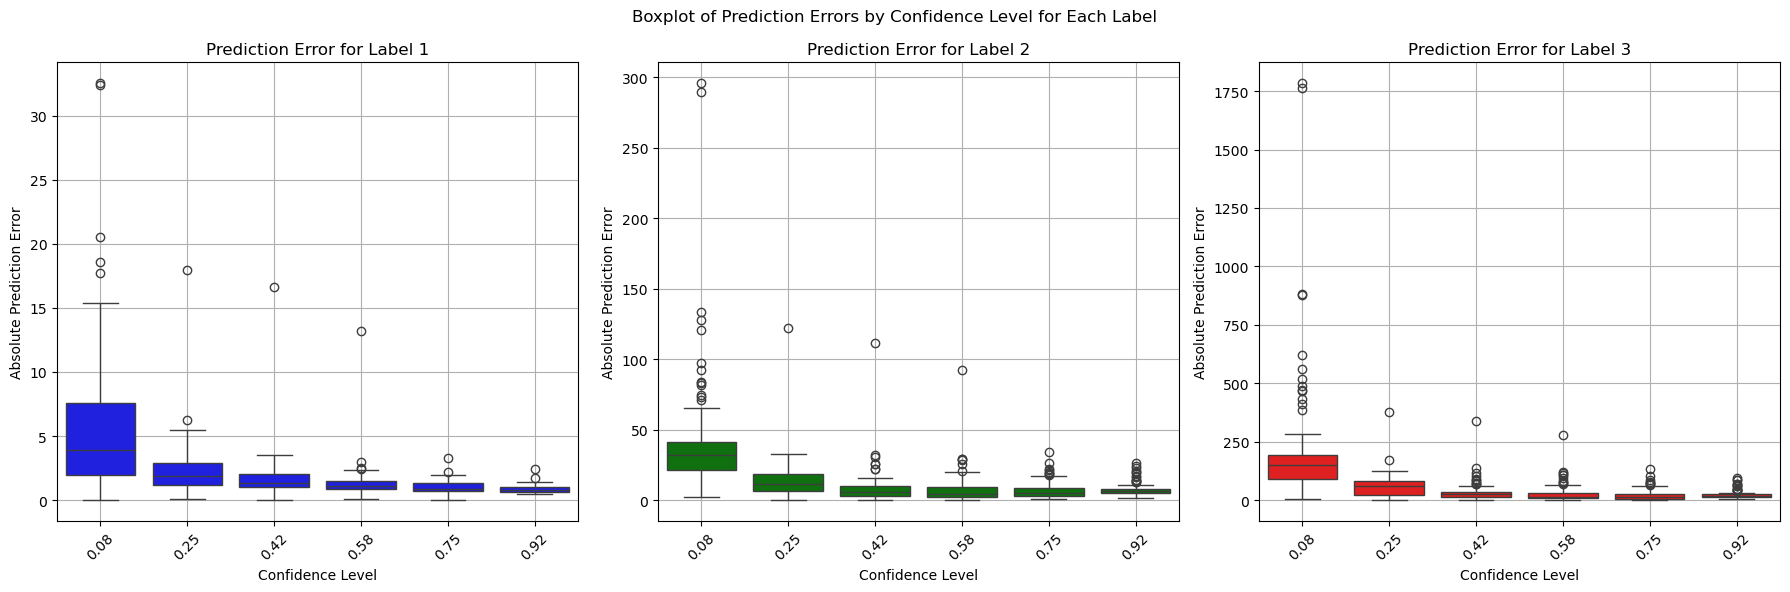

In [ ]:
# Convert lists to tensors for processing
outputs_all = torch.cat(outputs_list, dim=0).numpy()  # Shape: (N, 3)
labels_all = torch.cat(labels_list, dim=0).numpy()    # Shape: (N, 3)
conf_all = torch.cat(conf_list, dim=0).numpy()        # Shape: (N,)

# Sort by confidence values
sort_indices = np.argsort(conf_all)
conf_all = conf_all[sort_indices]
labels_all = labels_all[sort_indices]
outputs_all = outputs_all[sort_indices]

# Compute absolute errors (N, 3)
errors = np.abs(outputs_all - labels_all)

# Get the unique confidence values (6 discrete levels)
unique_conf_values = np.unique(conf_all)

# Group errors by confidence level, separately for each label
errors_per_conf = {conf: [[] for _ in range(3)] for conf in unique_conf_values}
for i in range(len(conf_all)):
    for label_idx in range(3):
        errors_per_conf[conf_all[i]][label_idx].append(errors[i, label_idx])

# Convert lists to numpy arrays for boxplot
errors_per_conf = {conf: [np.array(errs) for errs in errors_per_conf[conf]] for conf in unique_conf_values}

# Plot boxplots for each label with separate y-axis scales
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # No shared y-axis

label_colors = ['blue', 'green', 'red']
label_names = ['Label 1', 'Label 2', 'Label 3']

for i, ax in enumerate(axes):
    sns.boxplot(data=[errors_per_conf[conf][i] for conf in unique_conf_values], ax=ax, color=label_colors[i])
    ax.set_xticks(range(len(unique_conf_values)))
    ax.set_xticklabels([f"{conf:.2f}" for conf in unique_conf_values], rotation=45)
    ax.set_xlabel("Confidence Level")
    ax.set_title(f"Prediction Error for {label_names[i]}")
    ax.grid(True)

    # Separate y-axis for each subplot
    ax.set_ylabel("Absolute Prediction Error")

plt.suptitle("Boxplot of Prediction Errors by Confidence Level for Each Label")
plt.tight_layout()
plt.show()

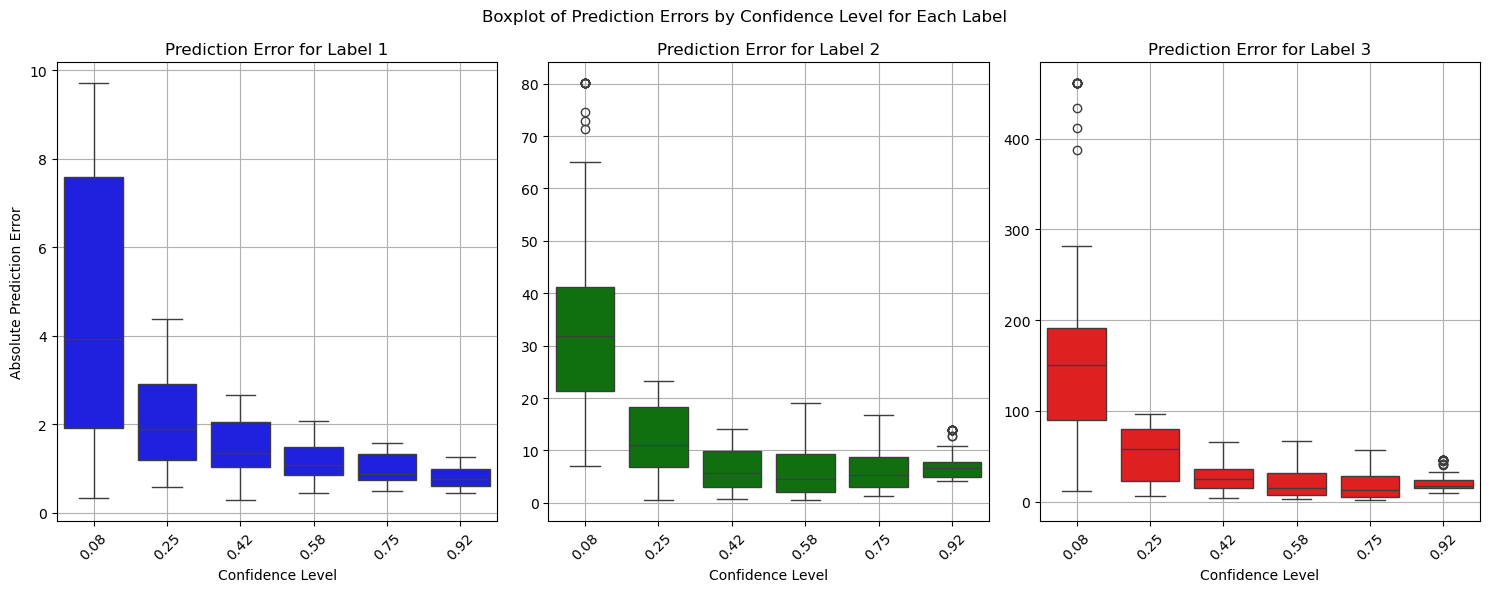

In [ ]:
# Apply clipping to each confidence level and label
errors_per_conf_clipped = {
    conf: [clip_outliers(np.array(errs),0.05,0.9) for errs in errors_per_conf[conf]]
    for conf in unique_conf_values
}

# Plot boxplots for each label
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=False)

label_colors = ['blue', 'green', 'red']
label_names = ['Label 1', 'Label 2', 'Label 3']

for i, ax in enumerate(axes):
    sns.boxplot(data=[errors_per_conf_clipped[conf][i] for conf in unique_conf_values], ax=ax, color=label_colors[i])
    ax.set_xticks(range(len(unique_conf_values)))
    ax.set_xticklabels([f"{conf:.2f}" for conf in unique_conf_values], rotation=45)
    ax.set_xlabel("Confidence Level")
    ax.set_title(f"Prediction Error for {label_names[i]}")
    ax.grid(True)

axes[0].set_ylabel("Absolute Prediction Error")
plt.suptitle("Boxplot of Prediction Errors by Confidence Level for Each Label")
plt.tight_layout()
plt.show()

In [ ]:
# Assuming `model` is your neural network
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 22642435


## Inference visualization

### Inference data loader

In [ ]:
class InferenceInputDataset(Dataset):
    def __init__(self, rgb_dir, ir_dir, rgb_transform=None, ir_transform=None):
        self.rgb_dir = rgb_dir
        self.ir_dir = ir_dir
        self.rgb_transform = rgb_transform
        self.ir_transform = ir_transform
    def __len__(self):

        return sum(1 for f in os.listdir(self.rgb_dir) if os.path.isfile(os.path.join(self.rgb_dir, f)))

    def __getitem__(self, idx):
        rgb_img_name = os.path.join(self.rgb_dir+'/image_56_patch_'+str(idx)+'.jpg')
        ir_img_name = os.path.join(self.ir_dir+'/image_56_patch_'+str(idx)+'.jpg')

        rgb_image = Image.open(rgb_img_name).convert('RGB')
        ir_image = Image.open(ir_img_name).convert('L')  # Convert to grayscale

        if self.rgb_transform:
            rgb_image = self.rgb_transform(rgb_image)
        if self.ir_transform:
            ir_image = self.ir_transform(ir_image)

        return rgb_image, ir_image

In [ ]:
# Filepaths for the validation dataset (completely different dataset)
vis_rgb_dir = "/media/philip/Elements/speciale_dataset/visualization/patches/RGB_patches"  # Replace with your validation RGB path
vis_ir_dir = "/media/philip/Elements/speciale_dataset/visualization/patches/IR_patches"    # Replace with your validation IR path

vis_dataset = InferenceInputDataset(vis_rgb_dir, vis_ir_dir, rgb_transform=rgb_transform, ir_transform=ir_transform)

vis_loader = DataLoader(vis_dataset, batch_size=1, shuffle=False)  # Validation set from a different dataset

In [ ]:
# Validation loop
model.eval()
running_val_loss = 0.0
outputs_list, labels_list, conf_list = [], [], []

with torch.no_grad():
            for rgb_images, ir_images in vis_loader:
                rgb_images = rgb_images.to(device)
                ir_images = ir_images.to(device)

                outputs = model(rgb_images, ir_images)
                outputs = outputs.squeeze()

                # Store outputs, labels, and confidence for visualization
                outputs_list.append(outputs.cpu())



### Visualization

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from shapely.geometry import Polygon, Point

def make_polygon_with_dim(corners):
    corners = np.array(corners)

    old_polygon = Polygon(corners)

    min_x, min_y, max_x, max_y = old_polygon.bounds

    width = max_x-min_x

    height = max_y-min_y

    new_corners = [[0,0],[width,0],[width,height],[0,height]]

    return new_corners



def generate_gradient(image_size, regions, sigma=10):
    """
    Creates a smooth gradient blending normalized values across an image.

    Parameters:
        image_size (tuple): (height, width) of the output image.
        regions (list): Each region is (polygon, value), where polygon is a list of (x, y) points.
        sigma (int): Gaussian blur strength for smoothing.

    Returns:
        np.array: Gradient image (same size as input image).
    """
    height, width = image_size
    value_map = np.zeros((height, width), dtype=np.float32)
    weight_map = np.zeros((height, width), dtype=np.float32)

    # Iterate over regions and populate value map
    for polygon_points, value in regions:
        poly = Polygon(polygon_points)

        # Rasterize the region
        for y in range(height):
            for x in range(width):
                if poly.contains(Point(x, y)):
                    value_map[y, x] += value  # Accumulate value
                    #print(value)
                    weight_map[y, x] += 1     # Track weight



    # Avoid division by zero and compute the blended map
    weight_map[weight_map == 0] = 1
    blended_map = value_map / weight_map

    # Apply Gaussian blur for a smooth gradient
    smoothed_map = gaussian_filter(blended_map, sigma=sigma)

    return smoothed_map

In [ ]:
def segment_region_validation(corners, N, center_spacing):
    """
    Segments a quadrilateral region into fixed-width, vertically spaced segments.

    Parameters:
        corners (array-like): Four (x, y) points defining the region.
        N (int): Number of equal-height segments along the total height.
        center_spacing (float): Vertical spacing (dy) between segment centers.

    Returns:
        List of valid segment corners, each as a tuple of 4 corner points.
    """
    # Convert to NumPy array for easy indexing
    corners = np.array(corners)

    # Define the polygon region
    polygon = Polygon(corners)

    # Get bounding box of the region
    min_x, min_y, max_x, max_y = polygon.bounds

    # Compute segment width (equal to polygon width)
    segment_w = max_x - min_x

    # Compute segment height (total height divided into N parts)
    segment_h = (max_y - min_y) / N

    # Compute fixed x-position (center of the bounding box width)
    x_center = (min_x + max_x) / 2

    # List to store valid segment corners
    valid_segments = []

    # Iterate over potential segment centers along the y-axis
    y = min_y + segment_h / 2  # Start at half-segment height
    while y + segment_h / 2 <= max_y:  # Ensure full segment stays inside the region
        center = Point(x_center, y)
        if polygon.contains(center):  # Ensure segment center is inside the region
            # Compute segment corners
            top_left = (x_center - segment_w / 2, y - segment_h / 2)
            top_right = (x_center + segment_w / 2, y - segment_h / 2)
            bottom_left = (x_center - segment_w / 2, y + segment_h / 2)
            bottom_right = (x_center + segment_w / 2, y + segment_h / 2)
            valid_segments.append((top_left, top_right, bottom_right, bottom_left))

        y += center_spacing  # Move to the next position

    return np.array(valid_segments), (int(max_y-min_y),int(max_x-min_x))

In [ ]:

Homography_bounds = [[422.102466 ,  204.07399483],[858.09274131, 204.07399483],[858.09274131 ,554.85492905],[422.102466  , 554.85492905]]

new_pol = make_polygon_with_dim(Homography_bounds)



segments, dim = segment_region_validation(new_pol,6,10)
seg_w_weight1,seg_w_weight2,seg_w_weight3 = [],[],[]
value_list = []
#min_val, max_val = np.min(outputs_list[:][0]), np.max(outputs_list[:][0])

for i in range(len(segments)):
    value1 = outputs_list[i][0].item()
    value2 = outputs_list[i][1].item()
    value3 = outputs_list[i][2].item()
    seg_w_weight1.append((segments[i],value1))
    seg_w_weight2.append((segments[i],value2))
    seg_w_weight3.append((segments[i],value3))
# value_list = np.array(value_list)

# min_val, max_val = np.min(value_list), np.max(value_list)

# norm_vals = []

# for i in range(len(value_list)):
#     norm = (value_list[i]-min_val)/(max_val - min_val + 1e-6)




gradient_map1 = generate_gradient(dim,seg_w_weight1,10)
gradient_map2 = generate_gradient(dim,seg_w_weight2,10)
gradient_map3 = generate_gradient(dim,seg_w_weight3,10)


In [ ]:
print(seg_w_weight3)

[(array([[  0.        ,   0.        ],
       [435.99027531,   0.        ],
       [435.99027531,  58.46348904],
       [  0.        ,  58.46348904]]), 50.585845947265625), (array([[  0.        ,  10.        ],
       [435.99027531,  10.        ],
       [435.99027531,  68.46348904],
       [  0.        ,  68.46348904]]), 54.32367706298828), (array([[  0.        ,  20.        ],
       [435.99027531,  20.        ],
       [435.99027531,  78.46348904],
       [  0.        ,  78.46348904]]), 57.5328369140625), (array([[  0.        ,  30.        ],
       [435.99027531,  30.        ],
       [435.99027531,  88.46348904],
       [  0.        ,  88.46348904]]), 56.18310546875), (array([[  0.        ,  40.        ],
       [435.99027531,  40.        ],
       [435.99027531,  98.46348904],
       [  0.        ,  98.46348904]]), 67.98908233642578), (array([[  0.        ,  50.        ],
       [435.99027531,  50.        ],
       [435.99027531, 108.46348904],
       [  0.        , 108.46348904]

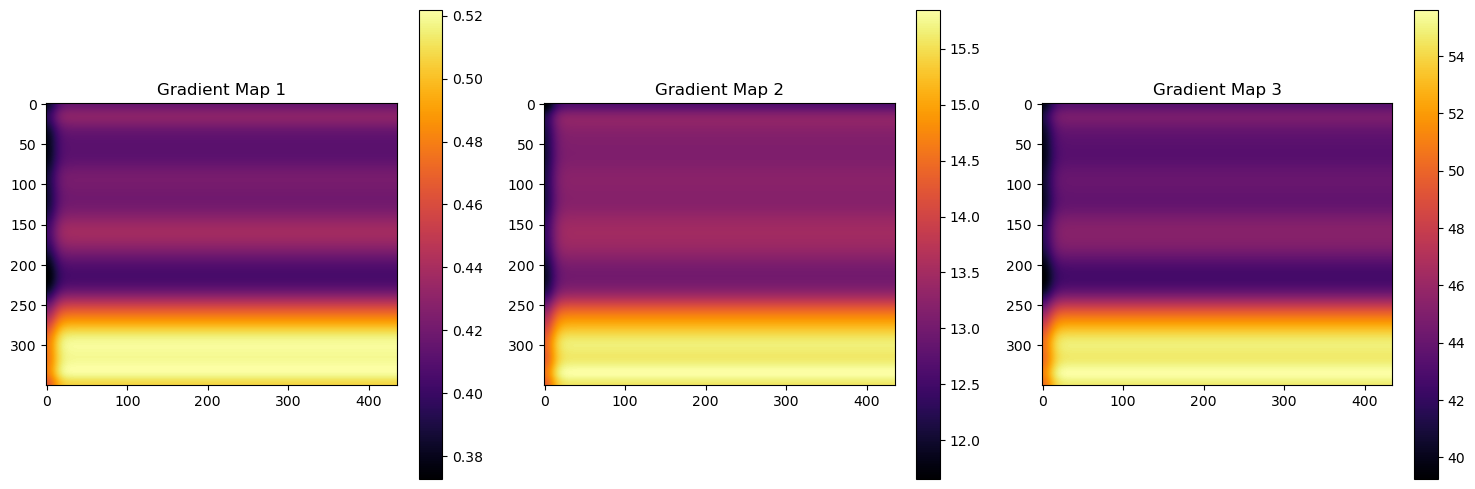

In [ ]:
#  Create a subplot with 3 axes (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each gradient map in a subplot and add a color bar
cbar1 = axs[0].imshow(gradient_map1, cmap='inferno')
axs[0].set_title("Gradient Map 1")
axs[0].axis('on')  # Turn off axis
fig.colorbar(cbar1, ax=axs[0], orientation='vertical')

cbar2 = axs[1].imshow(gradient_map2, cmap='inferno')
axs[1].set_title("Gradient Map 2")
axs[1].axis('on')  # Turn off axis
fig.colorbar(cbar2, ax=axs[1], orientation='vertical')

cbar3 = axs[2].imshow(gradient_map3, cmap='inferno')
axs[2].set_title("Gradient Map 3")
axs[2].axis('on')  # Turn off axis
fig.colorbar(cbar3, ax=axs[2], orientation='vertical')

# Adjust spacing
plt.tight_layout()

# Show the plots
plt.show()

In [2]:
def plot_loss_from_folders(train_folder, test_folder, val_folder):
    folders = {"Train": train_folder, "Test": test_folder, "Validation": val_folder}
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=False)

    for ax, (label, folder) in zip(axes, folders.items()):
        for file in sorted(os.listdir(folder)):
            if file.endswith(".csv"):
                file_path = os.path.join(folder, file)
                df = pd.read_csv(file_path)
                if "Step" in df.columns and "Value" in df.columns:
                    ax.plot(df["Step"].to_numpy(), df["Value"].to_numpy(), label=file[:-4])

        ax.set_title(f"{label} Loss")
        ax.set_xlabel("Step")
        ax.set_ylabel("Value")
        ax.legend()

    plt.tight_layout()
    plt.show()

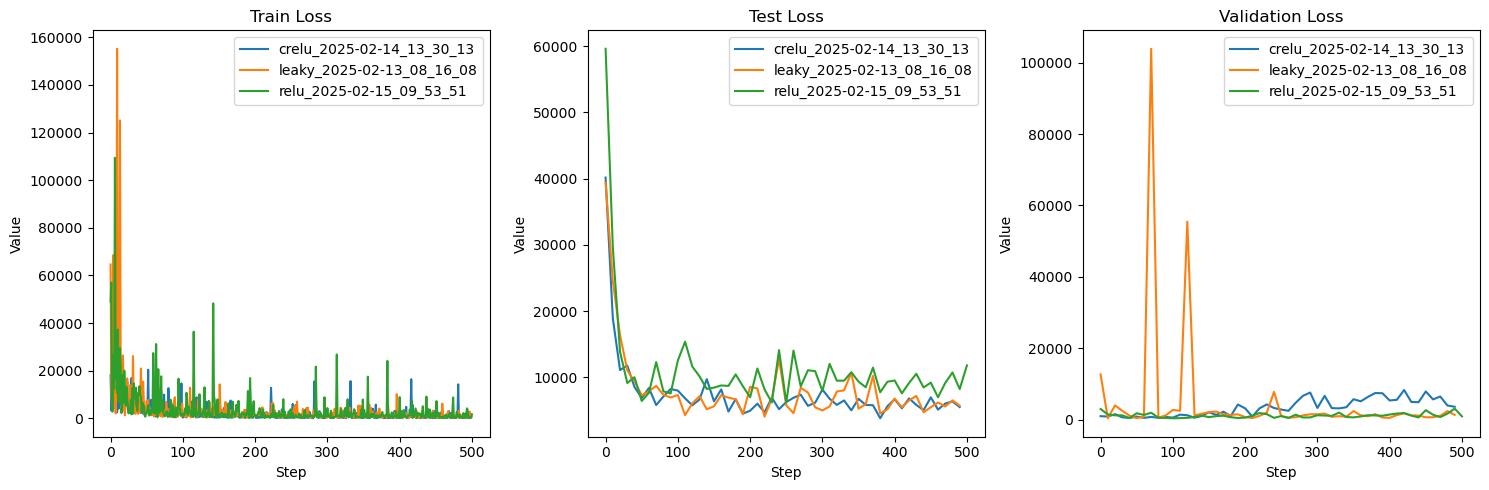

In [ ]:
plot_loss_from_folders('/home/philip/Documents/speciale_losses/train/','/home/philip/Documents/speciale_losses/test','/home/philip/Documents/speciale_losses/val')

In [ ]:
def plot_loss_from_folders_separate(train_folder, test_folder, val_folder):
    folders = {"Train": train_folder, "Test": test_folder, "Validation": val_folder}
    
    # Collect all unique filenames without extension across folders
    file_names = set()
    for folder in folders.values():
        for file in os.listdir(folder):
            if file.endswith(".csv"):
                file_names.add(file[:-4])  # Remove '.csv' extension

    # Create a separate figure for each unique file (label)
    for file_name in sorted(file_names):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=False)
        
        for ax, (label, folder) in zip(axes, folders.items()):
            file_path = os.path.join(folder, file_name + ".csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                if "Step" in df.columns and "Value" in df.columns:
                    ax.plot(df["Step"].to_numpy(), df["Value"].to_numpy(), label=file_name)
                    
            ax.set_title(f"{label} Loss for {file_name}")
            ax.set_xlabel("Step")
            ax.set_ylabel("Value")
            ax.legend()
        
        plt.tight_layout()
        plt.show()


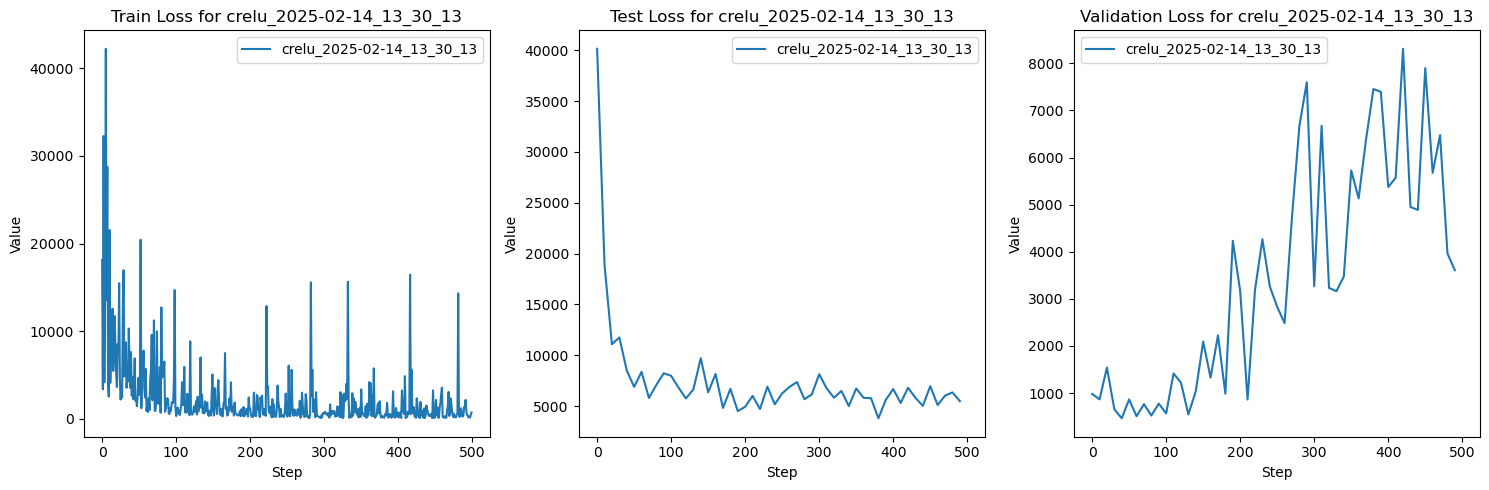

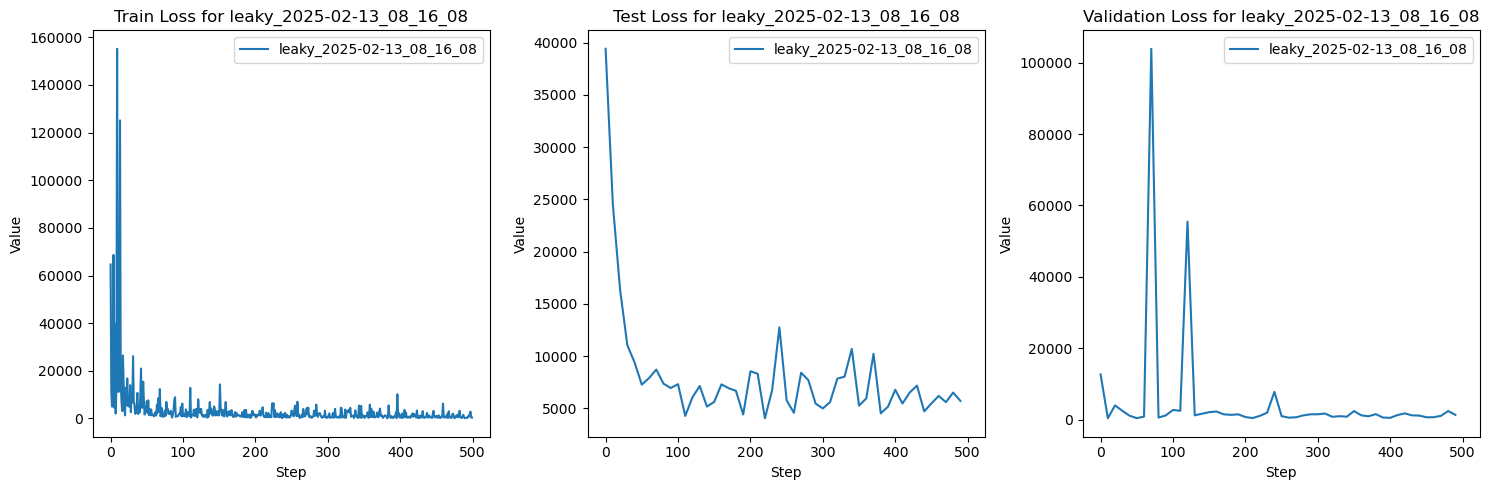

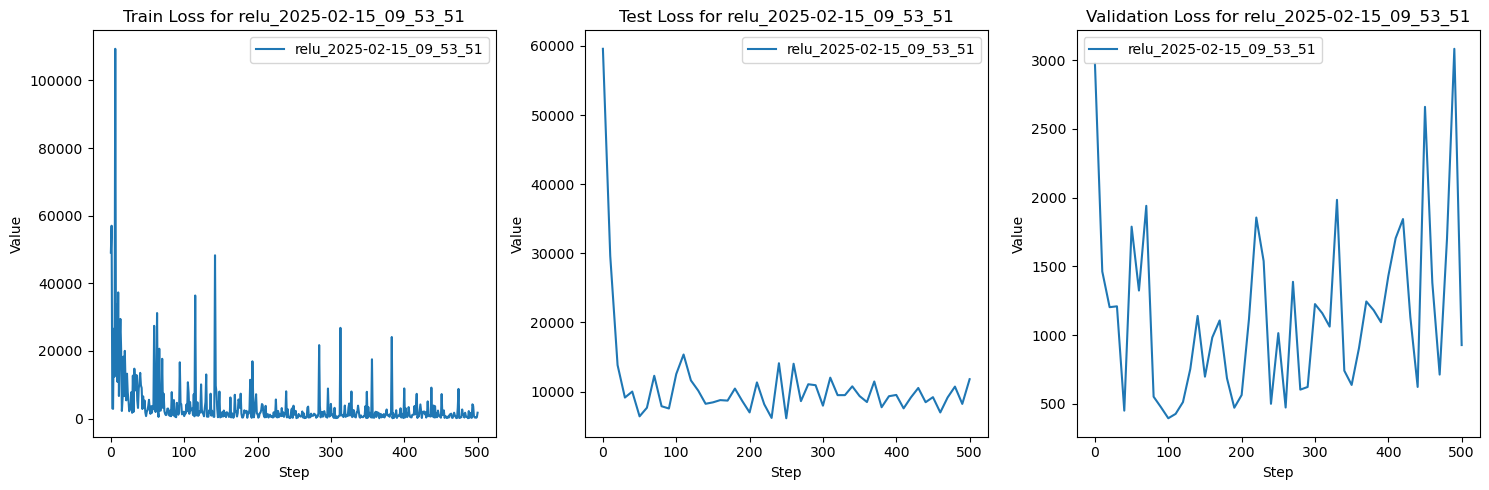

In [6]:
plot_loss_from_folders_separate('/home/philip/Documents/speciale_losses/train/','/home/philip/Documents/speciale_losses/test','/home/philip/Documents/speciale_losses/val')

# Evaluation of mono input (RGB)

In [3]:
class SingleInputDataset(Dataset):
    def __init__(self, rgb_dir, annotations_file, rgb_transform=None):
        self.rgb_dir = rgb_dir
        self.annotations = pd.read_csv(annotations_file)
        self.rgb_transform = rgb_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        rgb_img_name = os.path.join(self.rgb_dir, self.annotations.iloc[idx, 0])
        label1 = self.annotations.iloc[idx, 2]  # First label
        label2 = self.annotations.iloc[idx, 3]  # Second label
        label3 = self.annotations.iloc[idx,4]
        confidence = self.annotations.iloc[idx, 5]  # Confidence value

        rgb_image = Image.open(rgb_img_name).convert('RGB')

        if self.rgb_transform:
            rgb_image = self.rgb_transform(rgb_image)

        return rgb_image, label1, label2, label3, confidence

In [4]:
class SISONet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SISONet, self).__init__()
        self.resnet_rgb = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Remove the final fully connected layer from both ResNets
        self.resnet_rgb = nn.Sequential(*list(self.resnet_rgb.children())[:-1])

        # Define the final fully connected layers with dropout
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(), #CReLU(),#nn.LeakyReLU(),#
            nn.Dropout(dropout_prob),  # Dropout after the first ReLU
            nn.Linear(256, 128),
            nn.LeakyReLU(), #CReLU(),#nn.LeakyReLU(),#nn.ReLU(),#CReLU(),#nn.LeakyReLU(),#CReLU(),#
            nn.Dropout(dropout_prob),  # Dropout after the second ReLU
            nn.Linear(128, 3)  # Output 3 values for the three labels
        )

    def forward(self, rgb_image):
        rgb_features = self.resnet_rgb(rgb_image)

        # Flatten the features
        rgb_features = rgb_features.view(rgb_features.size(0), -1)


        # Pass through the final fully connected layer
        output = self.fc(rgb_features)
        return output

In [5]:
# Define transformations for RGB images
rgb_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB
])

# Create dataset and data loader
rgb_dir =Combined_out+"RGB_patches" # prep.merge_image_datasets_wPattern("/media/philip/Elements/speciale_dataset/data/", Combined_out, "RGB_patches" )#
annotations_file = Combined_out+"merged_dataset.csv"#prep.combine_csv("/media/philip/Elements/speciale_dataset/data/", Combined_out)#

dataset = SingleInputDataset(rgb_dir, annotations_file, rgb_transform=rgb_transform)
# Split the dataset into training, validation, and testing sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
#train_indices, val_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
#val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Init model

In [7]:
# # Initialize the network, loss function, and optimizer

device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
model = SISONet().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [8]:

state_dict = torch.load("model_weights/2025-02-27_13:20:56_350_prelu_model_weight.pth")
model.load_state_dict(state_dict)

/tmp/ipykernel_8017/985051413.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("model_weights/2025-02-27_13:20:56_350_prelu_model_weight.pth")


<All keys matched successfully>

In [9]:
def weighted_mse_loss(outputs, labels, confidence):
    """
    Compute weighted MSE loss.

    Args:
        outputs (torch.Tensor): Model predictions of shape (batch_size, num_outputs).
        labels (torch.Tensor): Ground truth labels of shape (batch_size, num_outputs).
        confidence (torch.Tensor): Confidence values of shape (batch_size,).

    Returns:
        torch.Tensor: Weighted MSE loss.
    """
    # Compute squared errors
    squared_errors = (outputs - labels) ** 2  # Shape: (batch_size, num_outputs)

    # Weight the squared errors by confidence
    weighted_squared_errors = squared_errors * confidence.unsqueeze(1)  # Shape: (batch_size, num_outputs)

    # Compute the mean of the weighted squared errors
    loss = weighted_squared_errors.mean()
    return loss

### Validation data

In [10]:
# Filepaths for the validation dataset (completely different dataset)
val_rgb_dir = "/media/philip/Elements/speciale_dataset/validation/data_set0/RGB_patches"  # Replace with your validation RGB path
#val_ir_dir = "/media/philip/Elements/speciale_dataset/validation/data_set0/IR_patches"    # Replace with your validation IR path
val_annotations_file = "/media/philip/Elements/speciale_dataset/validation/data_set0/annotations.csv"  # Replace with your validation annotations path

val_dataset = SingleInputDataset(val_rgb_dir,  val_annotations_file, rgb_transform=rgb_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Validation set from a different dataset

In [11]:
s = time.gmtime(time.time())
logs_address = 'logs/'+time.strftime('%Y-%m-%d_%H:%M:%S',s)+'single_input'
writer = SummaryWriter(logs_address)

In [12]:
# Early stopping parameters
patience = 100  # Number of test evaluations to wait before stopping
min_delta = 0.001  # Minimum improvement required to reset patience
best_loss = float('inf')  # Initialize best loss as infinity
epochs_without_improvement = 0  # Counter for patience

load_nr = 350
num_epochs = 501-load_nr
test_losses = []  # Store test losses


outputs_list, labels_list, conf_list = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for rgb_images, label1, label2, label3, confidence in train_loader:
        rgb_images = rgb_images.to(device)
        label1 = label1.float().to(device)
        label2 = label2.float().to(device)
        label3 = label3.float().to(device)
        confidence = confidence.float().to(device)

        optimizer.zero_grad()

        outputs = model(rgb_images)
        outputs = outputs.squeeze()
        labels = torch.stack((label1, label2, label3), dim=1)  # Combine labels

        # Compute weighted MSE loss
        loss = weighted_mse_loss(outputs, labels, confidence)
        loss.backward()
        optimizer.step()

        writer.add_scalar("Loss/Train", loss, epoch+load_nr)
        running_train_loss += loss.item()

    # Save model every 50 epochs
    if epoch % 50 == 0:
        torch.save(model.state_dict(), 'model_weights/' + time.strftime('%Y-%m-%d_%H:%M:%S', time.gmtime()) + f'_{load_nr+epoch}_prelu_model_weight.pth')

    # Run test every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for rgb_images, label1, label2, label3, confidence in test_loader:
                rgb_images = rgb_images.to(device)
                label1 = label1.float().to(device)
                label2 = label2.float().to(device)
                label3 = label3.float().to(device)
                confidence = confidence.float().to(device)

                outputs = model(rgb_images)
                outputs = outputs.squeeze()
                labels = torch.stack((label1, label2, label3), dim=1)

                loss = weighted_mse_loss(outputs, labels, confidence)
                running_test_loss += loss.item()

        test_loss = running_test_loss / len(test_loader)
        test_losses.append((epoch, test_loss))
        writer.add_scalar("Loss/Test", test_loss, epoch+load_nr)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')

        # Early stopping logic
        if best_loss - test_loss > min_delta:
            best_loss = test_loss
            epochs_without_improvement = 0  # Reset patience counter
        else:
            epochs_without_improvement += 1
            print(f'No significant improvement in test loss for {epochs_without_improvement}/{patience} evaluations.')

        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}.')
            break  # Stop training

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for rgb_images, label1, label2, label3, confidence in val_loader:
                rgb_images = rgb_images.to(device)
                label1 = label1.float().to(device)
                label2 = label2.float().to(device)
                label3 = label3.float().to(device)
                confidence = confidence.float().to(device)

                outputs = model(rgb_images)
                outputs = outputs.squeeze()
                labels = torch.stack((label1, label2, label3), dim=1)

                # Store outputs, labels, and confidence for visualization
                outputs_list.append(outputs.cpu())
                labels_list.append(labels.cpu())
                conf_list.append(confidence.cpu())

                # Compute weighted MSE loss (original labels, no modification)
                loss = weighted_mse_loss(outputs, labels, confidence)
                running_val_loss += loss.item()

            # Calculate average validation loss
            val_loss = running_val_loss / len(val_loader)
            writer.add_scalar("Loss/Val", val_loss, epoch+load_nr)
            print(f'Validation Loss: {val_loss:.4f}')
    # Print epoch loss
    train_loss = running_train_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')

Epoch [1/151], Test Loss: 5915.3590
Validation Loss: 1210.1371
Epoch [1/151], Train Loss: 2272.9073
Epoch [2/151], Train Loss: 2269.5573
Epoch [3/151], Train Loss: 2160.0728
Epoch [4/151], Train Loss: 2575.5360
Epoch [5/151], Train Loss: 2975.1965
Epoch [6/151], Train Loss: 2539.6874
Epoch [7/151], Train Loss: 2123.8391
Epoch [8/151], Train Loss: 2044.5067
Epoch [9/151], Train Loss: 2058.3345
Epoch [10/151], Train Loss: 1995.0655
Epoch [11/151], Test Loss: 6532.6676
No significant improvement in test loss for 1/100 evaluations.
Validation Loss: 299499.8908
Epoch [11/151], Train Loss: 2199.3759
Epoch [12/151], Train Loss: 1913.7926
Epoch [13/151], Train Loss: 2300.5605
Epoch [14/151], Train Loss: 1848.7054
Epoch [15/151], Train Loss: 1977.1076
Epoch [16/151], Train Loss: 1943.3602
Epoch [17/151], Train Loss: 1811.4801
Epoch [18/151], Train Loss: 2059.7709
Epoch [19/151], Train Loss: 1948.2784
Epoch [20/151], Train Loss: 2015.6896
Epoch [21/151], Test Loss: 6609.1546
No significant impro

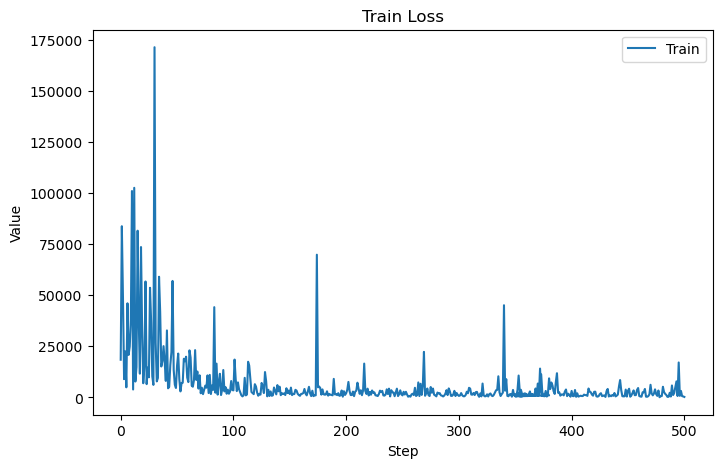

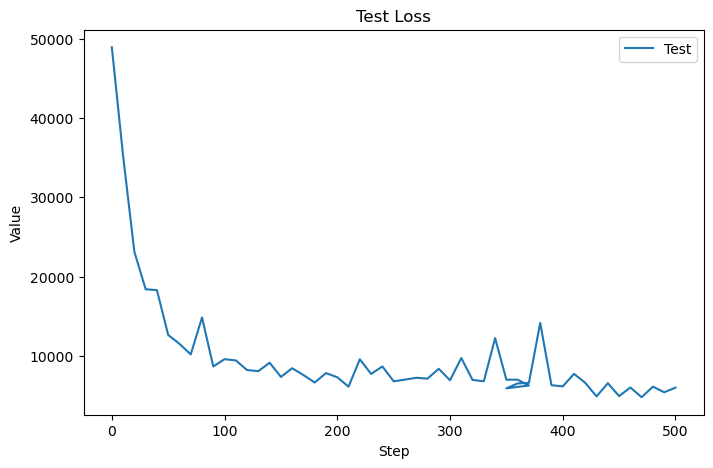

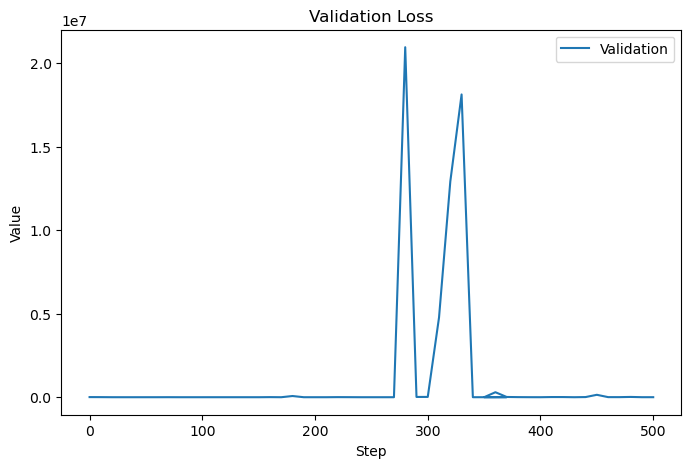

In [39]:
def plot_loss_from_folders_SISO(train_folder, test_folder, val_folder):
    folders = {"Train": train_folder, "Test": test_folder, "Validation": val_folder}

    for label, folder in folders.items():
        file_list = sorted([f for f in os.listdir(folder) if f.endswith(".csv")])
        
        if len(file_list) < 2:
            print(f"Skipping {label}: Less than 2 files found.")
            continue  # Ensure we have at least 2 files to concatenate
        
        file1_path = os.path.join(folder, file_list[0])
        file2_path = os.path.join(folder, file_list[1])
        
        # Read first file and take first 350 rows
        df1 = pd.read_csv(file1_path)
        
        # Read second file fully
        df2 = pd.read_csv(file2_path)
        
        # Concatenate
        df = pd.concat([df1, df2], ignore_index=True)
        
        # Check if required columns exist
        if "Step" not in df.columns or "Value" not in df.columns:
            print(f"Skipping {label}: Missing 'Step' or 'Value' columns.")
            continue
        
        # Convert to NumPy before plotting (Fix for ValueError)
        plt.figure(figsize=(8, 5))
        plt.plot(df["Step"].to_numpy(), df["Value"].to_numpy(), label=label)
        plt.title(f"{label} Loss")
        plt.xlabel("Step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

plot_loss_from_folders_SISO('/home/philip/Documents/speciale_losses/single_input/train/','/home/philip/Documents/speciale_losses/single_input/test','/home/philip/Documents/speciale_losses/single_input/validation')
